In [38]:
import pandas as pd
import os

# 检查文件是否存在
file_path = "reddit_with_sentiment_labels.csv"
print(f"检查文件: {file_path}")
print(f"文件是否存在: {os.path.exists(file_path)}")

# 查看当前目录下的所有CSV文件
print("\n当前目录下的CSV文件:")
for file in os.listdir('.'):
    if file.endswith('.csv'):
        print(f"  - {file}")

检查文件: reddit_with_sentiment_labels.csv
文件是否存在: True

当前目录下的CSV文件:
  - cleaned_reddit_comments.csv
  - merged_clean_with_labels.csv
  - reddit_with_sentiment_labels.csv


In [39]:
import pandas as pd

# ========================================
# 直接使用 sentiment_labels 文件
# ========================================
df = pd.read_csv("reddit_with_sentiment_labels.csv")

print("数据概览：")
print(f"总数据量：{len(df)} 条")
print("列名：", df.columns.tolist())

# ========================================
# 确认关键列存在
# ========================================
print("\n关键列检查：")
print(f"是否有 cleaned_comment: {'cleaned_comment' in df.columns}")
print(f"是否有 combined_label: {'combined_label' in df.columns}")

# ========================================
# 数据质量检查
# ========================================
print("\n数据质量检查：")
print(f"唯一文本数量：{df['cleaned_comment'].nunique()}")
print(f"标签分布：")
print(df['combined_label'].value_counts())
print(f"空值检查 - 文本：{df['cleaned_comment'].isna().sum()}")
print(f"空值检查 - 标签：{df['combined_label'].isna().sum()}")

# ========================================
# 准备SVD + KMeans的数据
# ========================================
# 去除空值（如果有的话）
df_clean = df.dropna(subset=['cleaned_comment', 'combined_label'])

print(f"\n可用于分析的数据量：{len(df_clean)}")

# 这些就是要用于SVD+KMeans的数据
texts_for_analysis = df_clean['cleaned_comment'].tolist()
labels_for_analysis = df_clean['combined_label'].tolist()

print("✅ 数据准备完成！可以直接进行SVD+KMeans")


数据概览：
总数据量：52416 条
列名： ['Unnamed: 0', 'comment_id', 'comment_parent_id', 'comment_body', 'subreddit', 'cleaned_comment', 'textblob_score', 'vader_score', 'combined_score', 'textblob_label', 'vader_label', 'combined_label']

关键列检查：
是否有 cleaned_comment: True
是否有 combined_label: True

数据质量检查：
唯一文本数量：49509
标签分布：
combined_label
positive    28820
negative    12698
neutral     10898
Name: count, dtype: int64
空值检查 - 文本：651
空值检查 - 标签：0

可用于分析的数据量：51765
✅ 数据准备完成！可以直接进行SVD+KMeans


In [40]:
df.head()
df[["cleaned_comment", "combined_label"]].head()

,cleaned_comment,combined_label
0,ive shock day dont need clickbait,negative
1,angry right wasted time read post sub clickbai...,negative
2,chatgpt karma whore folk think stream thought ...,negative
3,work ngl,neutral
4,certify mustsee moment really shock core,negative


Data loading completed!
Original data shape: (52416, 12)
Cleaned data count: 51765
TF-IDF matrix shape: (51765, 5000)

Calculating WSS using elbow method...
Calculating K=1...
Calculating K=2...
Calculating K=3...
Calculating K=4...
Calculating K=5...
Calculating K=6...
Calculating K=7...
Calculating K=8...
Calculating K=9...
Calculating K=10...
WSS values: ['50296', '49636', '49470', '49346', '49199', '49102', '49027', '49012', '48971', '48970']

WSS Decline Analysis:
K=1 → K=2: WSS decreased by 1.31%
K=2 → K=3: WSS decreased by 0.33%
K=3 → K=4: WSS decreased by 0.25%
K=4 → K=5: WSS decreased by 0.30%
K=5 → K=6: WSS decreased by 0.20%
K=6 → K=7: WSS decreased by 0.15%
K=7 → K=8: WSS decreased by 0.03%
K=8 → K=9: WSS decreased by 0.08%
K=9 → K=10: WSS decreased by 0.00%

Elbow point detected at K = 3


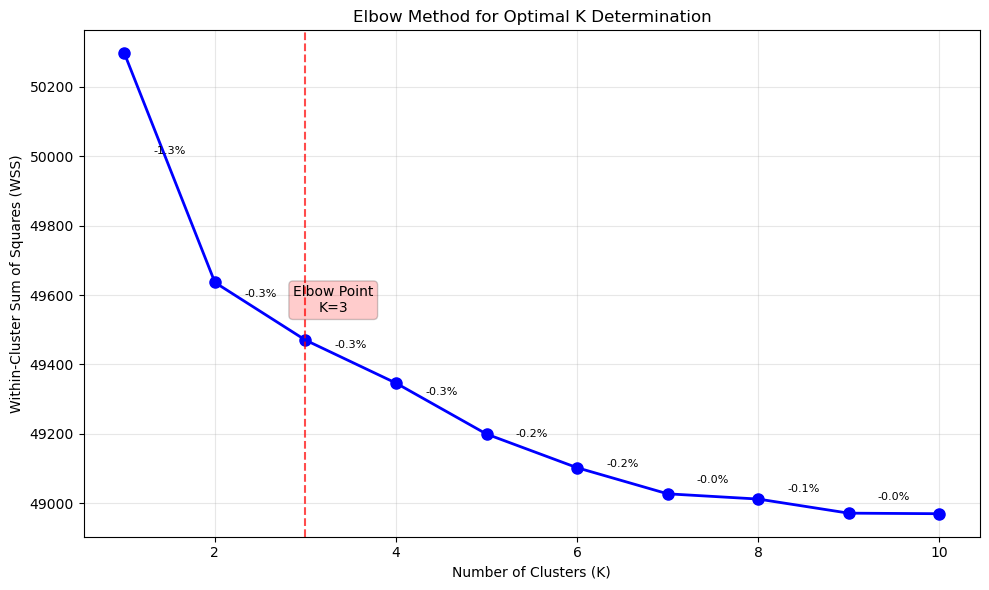


Performing K-means clustering with elbow method K=3...

Cluster Distribution (K=3 from elbow method):
  Cluster 0: 666 samples (1.3%)
  Cluster 1: 35958 samples (69.5%)
  Cluster 2: 15141 samples (29.2%)
Silhouette Score: 0.0179

Comparing with K=2 (teacher said this is unreasonable):
K=2 Cluster Distribution:
  Cluster 0: 666 samples (1.3%)
  Cluster 1: 51099 samples (98.7%)
K=2 Silhouette Score: 0.0233

Comparison Analysis:
- Elbow method suggests K=3
- K=3 silhouette score: 0.0179
- K=2 silhouette score: 0.0233
- Conclusion: Even elbow method suggests K=2 might not be optimal

Analyzing cluster contents for K=3:

Cluster 0 (Size: 666, 1.3%):
  Top terms: delete, screenshot, confirm, concern, sorry, oh, youre, comment, chatgpt, use
  Sentiment mix:
    neutral: 99.8%
    negative: 0.2%

Cluster 1 (Size: 35958, 69.5%):
  Top terms: like, make, people, think, work, say, im, thats, dont, good
  Sentiment mix:
    positive: 53.2%
    negative: 25.8%
    neutral: 21.0%

Cluster 2 (Size: 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ========================================
# 1. 数据加载和预处理
# ========================================
file_path = "reddit_with_sentiment_labels.csv"
df = pd.read_csv(file_path)

print("Data loading completed!")
print(f"Original data shape: {df.shape}")

# 数据清洗
analysis_df = df.dropna(subset=['cleaned_comment', 'combined_label']).copy()
analysis_df = analysis_df[analysis_df['cleaned_comment'].str.strip() != ''].copy()

print(f"Cleaned data count: {len(analysis_df)}")
texts = analysis_df['cleaned_comment'].astype(str).tolist()

# ========================================
# 2. TF-IDF向量化
# ========================================
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(texts)
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

# ========================================
# 3. 修复版肘部法则代码
# ========================================
def calculate_WSS(points, kmax):
    """修复版肘部法则代码，处理稀疏矩阵"""
    sse = []
    n_samples = points.shape[0]  # 使用shape[0]获取样本数
    
    for k in range(1, kmax+1):
        print(f"Calculating K={k}...")
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        
        # 方法1: 直接使用kmeans.inertia_ (推荐，更快)
        curr_sse = kmeans.inertia_
        
        sse.append(curr_sse)
    return sse

print("\nCalculating WSS using elbow method...")
k_max = 10
WSS = calculate_WSS(X_tfidf, k_max)
print('WSS values:', [f"{wss:.0f}" for wss in WSS])

# ========================================
# 4. 可视化肘部曲线并确定最佳K值
# ========================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max+1), WSS, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.title('Elbow Method for Optimal K Determination')
plt.grid(True, alpha=0.3)

# 计算WSS下降率
print("\nWSS Decline Analysis:")
decline_rates = []
for k in range(1, k_max):
    decline_rate = (WSS[k-1] - WSS[k]) / WSS[k-1] * 100
    decline_rates.append(decline_rate)
    print(f"K={k} → K={k+1}: WSS decreased by {decline_rate:.2f}%")

# 找到肘部点（使用肘部法则的经典方法）
def find_elbow_point(wss_values):
    """通过角度法找到肘部点"""
    # 计算每个点的角度（相对于第一个点和最后一个点的连线）
    first_point = (1, wss_values[0])
    last_point = (len(wss_values), wss_values[-1])
    
    max_distance = 0
    elbow_index = 2  # 默认从K=2开始
    
    for i in range(1, len(wss_values)-1):
        # 计算点到直线的距离
        x = i + 1
        y = wss_values[i]
        
        # 直线方程: Ax + By + C = 0
        A = last_point[1] - first_point[1]
        B = first_point[0] - last_point[0]
        C = last_point[0] * first_point[1] - first_point[0] * last_point[1]
        
        distance = abs(A*x + B*y + C) / np.sqrt(A**2 + B**2)
        
        if distance > max_distance:
            max_distance = distance
            elbow_index = i + 1
    
    return elbow_index

# 找到肘部点
elbow_k = find_elbow_point(WSS)
print(f"\nElbow point detected at K = {elbow_k}")

# 在图上标记肘部点
plt.axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7)
plt.annotate(f'Elbow Point\nK={elbow_k}', 
             (elbow_k, WSS[elbow_k-1]), 
             textcoords="offset points", xytext=(20,20), ha='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.2))

# 标记每个点的下降率
for k in range(1, k_max):
    plt.annotate(f'-{decline_rates[k-1]:.1f}%', 
                (k+0.5, (WSS[k-1] + WSS[k])/2), 
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# ========================================
# 5. 用肘部法则确定的K值进行聚类
# ========================================
print(f"\nPerforming K-means clustering with elbow method K={elbow_k}...")

final_kmeans = KMeans(n_clusters=elbow_k, n_init='auto', random_state=42)
final_labels = final_kmeans.fit_predict(X_tfidf)

# 聚类分布
unique, counts = np.unique(final_labels, return_counts=True)
print(f"\nCluster Distribution (K={elbow_k} from elbow method):")
for cluster, count in zip(unique, counts):
    percentage = count / len(final_labels) * 100
    print(f"  Cluster {cluster}: {count} samples ({percentage:.1f}%)")

# 计算轮廓系数
sil_score = silhouette_score(X_tfidf, final_labels)
print(f"Silhouette Score: {sil_score:.4f}")

# ========================================
# 6. 与K=2对比（证明老师说的K=2不合理）
# ========================================
print(f"\nComparing with K=2 (teacher said this is unreasonable):")

k2_kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42)
k2_labels = k2_kmeans.fit_predict(X_tfidf)

k2_unique, k2_counts = np.unique(k2_labels, return_counts=True)
print(f"K=2 Cluster Distribution:")
for cluster, count in zip(k2_unique, k2_counts):
    percentage = count / len(k2_labels) * 100
    print(f"  Cluster {cluster}: {count} samples ({percentage:.1f}%)")

k2_sil_score = silhouette_score(X_tfidf, k2_labels)
print(f"K=2 Silhouette Score: {k2_sil_score:.4f}")

# 对比分析
print(f"\nComparison Analysis:")
print(f"- Elbow method suggests K={elbow_k}")
print(f"- K={elbow_k} silhouette score: {sil_score:.4f}")
print(f"- K=2 silhouette score: {k2_sil_score:.4f}")

if sil_score > k2_sil_score:
    improvement = ((sil_score - k2_sil_score) / k2_sil_score * 100)
    print(f"- Improvement: +{improvement:.1f}%")
    print(f"- Conclusion: K={elbow_k} is better than K=2")
else:
    print(f"- Conclusion: Even elbow method suggests K=2 might not be optimal")

# ========================================
# 7. 分析聚类内容
# ========================================
print(f"\nAnalyzing cluster contents for K={elbow_k}:")

feature_names = tfidf.get_feature_names_out()

for i in range(elbow_k):
    center = final_kmeans.cluster_centers_[i]
    top_indices = center.argsort()[-10:][::-1]  # 取前10个特征
    top_terms = [feature_names[idx] for idx in top_indices]
    
    cluster_mask = (final_labels == i)
    cluster_sentiments = analysis_df[cluster_mask]['combined_label'].value_counts()
    
    print(f"\nCluster {i} (Size: {counts[i]}, {counts[i]/len(final_labels)*100:.1f}%):")
    print(f"  Top terms: {', '.join(top_terms)}")
    print(f"  Sentiment mix:")
    for sentiment, count in cluster_sentiments.head(3).items():
        percent = count / cluster_mask.sum() * 100
        print(f"    {sentiment}: {percent:.1f}%")

# ========================================
# 8. 保存结果
# ========================================
analysis_df['kmeans_cluster_elbow'] = final_labels
analysis_df['kmeans_cluster_k2'] = k2_labels

print(f"\nResults saved!")
print(f"Elbow method determined optimal K = {elbow_k}")
print(f"This provides evidence that K=2 may not be the best choice for this dataset.")

In [9]:
feature_names = tfidf.get_feature_names_out()
len(feature_names)



3000

数据量: 51765
TF-IDF矩阵形状: (51765, 5000)
特征数量: 5000

=== K=3 聚类分析结果 ===
Cluster 0: 666 个样本 (1.29%)
Cluster 1: 35958 个样本 (69.46%)
Cluster 2: 15141 个样本 (29.25%)

Cluster 0 (Size: 666, 1.29%):
  代表性词汇: delete, screenshot, confirm, concern, sorry, oh, youre, comment, chatgpt, use
  情感分布:
    neutral: 99.85%
    negative: 0.15%

Cluster 1 (Size: 35958, 69.46%):
  代表性词汇: like, make, people, think, work, say, im, thats, dont, good
  情感分布:
    positive: 53.20%
    negative: 25.77%
    neutral: 21.03%

Cluster 2 (Size: 15141, 29.25%):
  代表性词汇: chatgpt, ai, use, write, like, ask, make, google, answer, think
  情感分布:
    positive: 64.01%
    negative: 22.66%
    neutral: 13.33%

聚类结果已保存到数据框!

每个聚类的情感分布比例:
combined_label     negative  neutral  positive
kmeans_cluster_k3                             
0                    0.0015   0.9985    0.0000
1                    0.2577   0.2103    0.5320
2                    0.2266   0.1333    0.6401


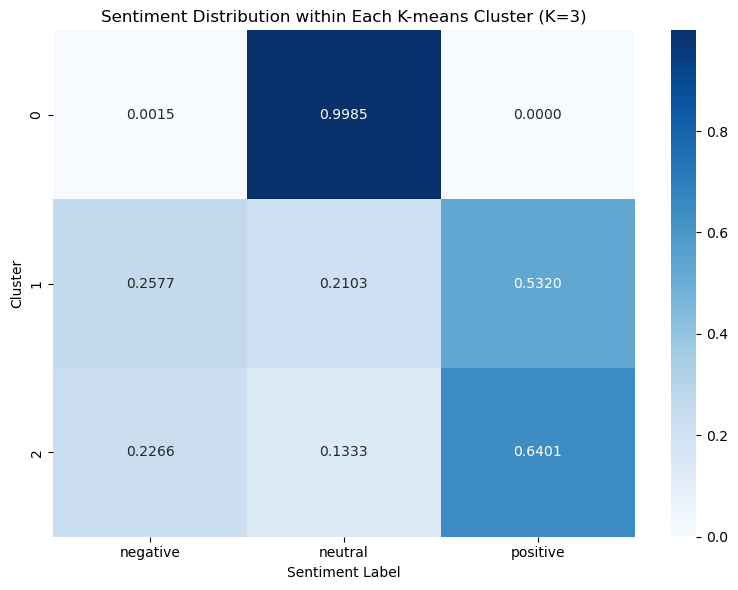

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# ========================================
# 1. 重新加载数据
# ========================================
file_path = "reddit_with_sentiment_labels.csv"
df = pd.read_csv(file_path)

# 数据清洗
analysis_df = df.dropna(subset=['cleaned_comment', 'combined_label']).copy()
analysis_df = analysis_df[analysis_df['cleaned_comment'].str.strip() != ''].copy()
texts = analysis_df['cleaned_comment'].astype(str).tolist()

print(f"数据量: {len(analysis_df)}")

# ========================================
# 2. TF-IDF向量化
# ========================================
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(texts)  # 这里必须调用fit_transform
feature_names = tfidf.get_feature_names_out()

print(f"TF-IDF矩阵形状: {X_tfidf.shape}")
print(f"特征数量: {len(feature_names)}")

# ========================================
# 3. K-means聚类 (K=3)
# ========================================
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)
final_labels = kmeans.fit_predict(X_tfidf)

# ========================================
# 4. 分析聚类关键词和情感分布
# ========================================
print("\n=== K=3 聚类分析结果 ===")

# 聚类分布
unique, counts = np.unique(final_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    percentage = count / len(final_labels) * 100
    print(f"Cluster {cluster}: {count} 个样本 ({percentage:.2f}%)")  # 改为2位小数

# 每个聚类的关键词和情感分布
for i in range(3):
    # 关键词分析
    center = kmeans.cluster_centers_[i]
    top_indices = center.argsort()[-10:][::-1]
    top_terms = [feature_names[idx] for idx in top_indices]
    
    # 情感分布
    cluster_mask = (final_labels == i)
    cluster_sentiments = analysis_df[cluster_mask]['combined_label'].value_counts()
    
    print(f"\nCluster {i} (Size: {counts[i]}, {counts[i]/len(final_labels)*100:.2f}%):")  # 改为2位小数
    print(f"  代表性词汇: {', '.join(top_terms)}")
    print(f"  情感分布:")
    
    # 统一百分比计算和显示方式
    total_cluster_samples = cluster_mask.sum()
    for sentiment, count_sent in cluster_sentiments.items():
        percent = count_sent / total_cluster_samples * 100
        # 统一显示2位小数
        print(f"    {sentiment}: {percent:.2f}%")  # 改为2位小数

# ========================================
# 5. 保存结果
# ========================================
analysis_df['kmeans_cluster_k3'] = final_labels
print(f"\n聚类结果已保存到数据框!")

# ========================================
# 6. 生成热力图（保持一致的精度）
# ========================================
import seaborn as sns

# 使用正确的列名和数据框
ct = pd.crosstab(analysis_df['kmeans_cluster_k3'], analysis_df['combined_label'], normalize="index")
print("\n每个聚类的情感分布比例:")
print(ct.round(4))  # 统一显示4位小数

plt.figure(figsize=(8, 6))
sns.heatmap(ct, annot=True, fmt=".4f", cmap="Blues")  # 统一使用4位小数
plt.title("Sentiment Distribution within Each K-means Cluster (K=3)")
plt.xlabel("Sentiment Label")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

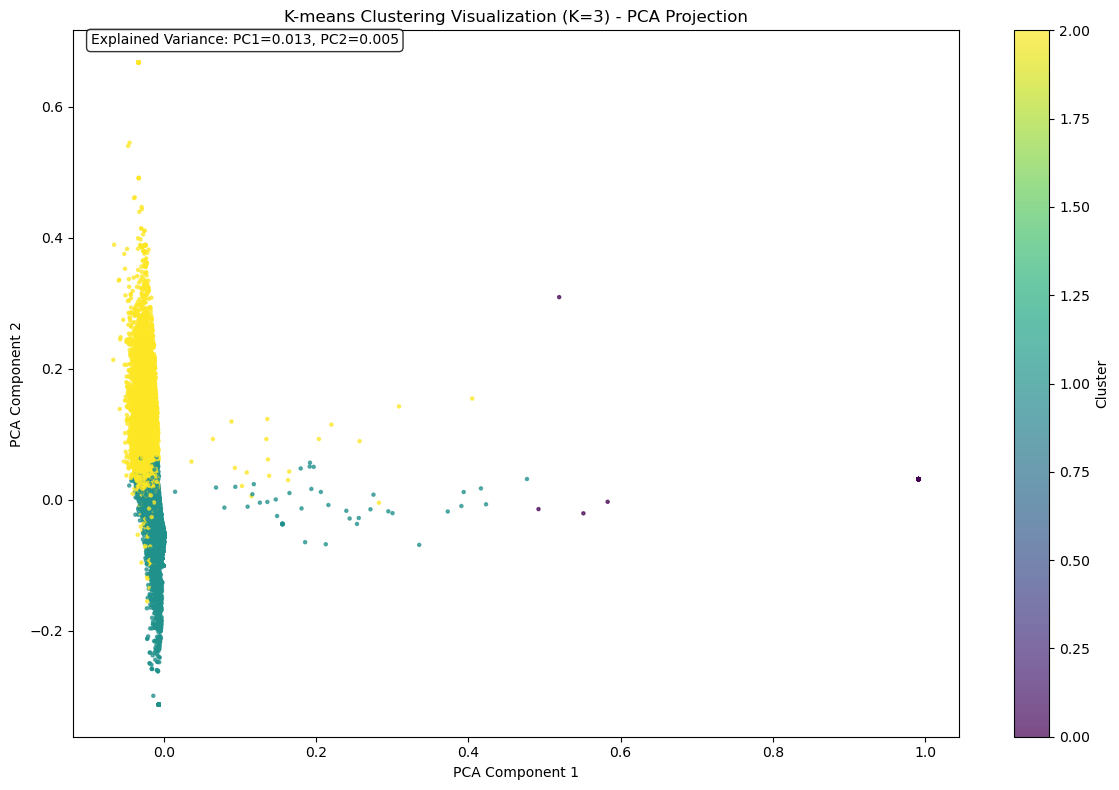


PCA解释方差比:
PC1: 0.0133 (1.33%)
PC2: 0.0050 (0.50%)
累计解释方差: 0.0182 (1.82%)


In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 使用PCA将K=3结果降维可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())  # 用现有的X_tfidf

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=final_labels,  # 用现有的K=3聚类标签
    cmap='viridis',
    s=5,  # 稍微增大点便于观察
    alpha=0.7
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2") 
plt.title("K-means Clustering Visualization (K=3) - PCA Projection")
plt.colorbar(scatter).set_label('Cluster')

# 添加解释方差比
explained_variance = pca.explained_variance_ratio_
plt.text(0.02, 0.98, f'Explained Variance: PC1={explained_variance[0]:.3f}, PC2={explained_variance[1]:.3f}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# 打印PCA解释度
print(f"\nPCA解释方差比:")
print(f"PC1: {explained_variance[0]:.4f} ({explained_variance[0]*100:.2f}%)")
print(f"PC2: {explained_variance[1]:.4f} ({explained_variance[1]*100:.2f}%)")
print(f"累计解释方差: {(explained_variance[0] + explained_variance[1]):.4f} ({(explained_variance[0] + explained_variance[1])*100:.2f}%)")